# SPAN Benchmarks H3K4me1

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
from itertools import product


In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts


# Hg38 load peaks

In [3]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K4me1']
GSE26320_REPS = ['rep1', 'rep2']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [4]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [5]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))


df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 17


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 17


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 17


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 17


,file,modification,cell,replicate,fdr,peaks,avlength,tool
13,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me1,K562,rep1,0.05,119713,445.769223,MACS2
7,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me1,GM12878,rep1,0.01,70985,2926.215609,SICER
9,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me1,H1,rep1,0.05,29669,314.994911,MACS2
0,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me1,HSMM,rep1,0.01,58438,3420.883021,SICER
2,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me1,HepG2,rep1,0.01,69630,3111.161425,SICER


In [6]:
df_fdr_peaks.to_csv(GSE26320_PATH_HG38 + '/df_fdr_peaks.csv.gz', index=False, compression='gzip')

In [7]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number

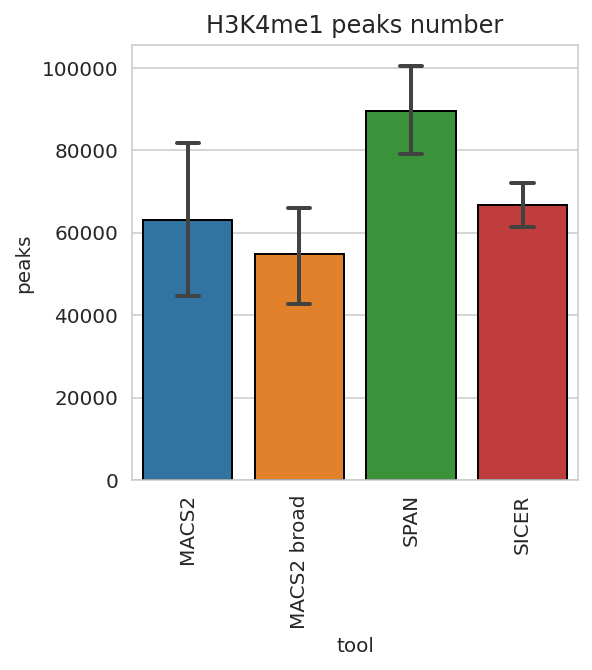

In [8]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=TOOLS)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K4me1 peaks number')
plt.show()

In [9]:
print('Load lengths')
ts = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(tool=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,tool,length
142370,MACS2,290
318631,MACS2 broad,1648
538783,SPAN,1385
5769,MACS2,266
230497,MACS2 broad,868
348353,SICER,1799
366812,SICER,3799
476210,SICER,3799
622372,SPAN,1624
183458,MACS2 broad,1949


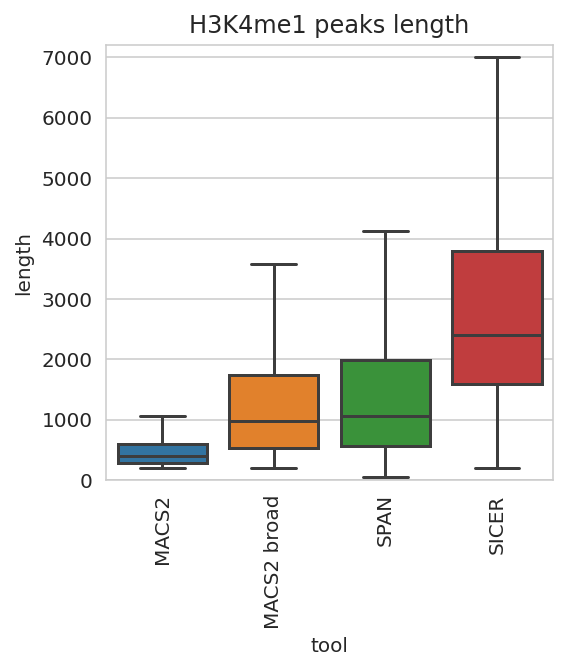

In [10]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='tool', y='length', ax=ax, order=TOOLS, showfliers=False)
ax.title.set_text('H3K4me1 peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 7200])
plt.show()

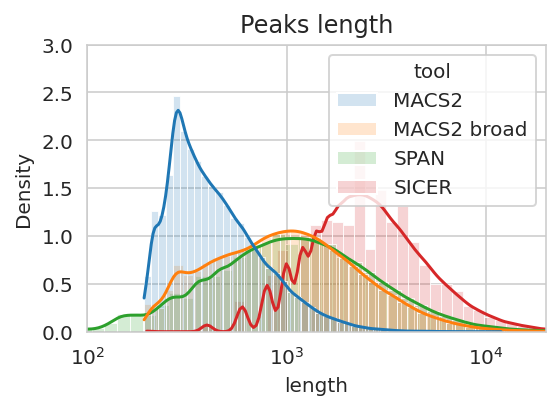

In [11]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=TOOLS)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
# # Randomly tweak SPAN, SICER lengths for visualization purposes
# tspan = t['tool'] == 'SPAN'
# t.loc[tspan, 'length'] += np.random.normal(0, 100, size=sum(tspan))
# tsicer = t['tool'] == 'SICER'
# t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))

In [13]:
# plt.figure(figsize=(8, 5))
# ax = plt.axes()
# g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
#                          stat='density', common_bins=False, common_norm=False,
#                          kde=True, log_scale=True, alpha=0.2,
#                          palette=TOOLS_PALETTE)
# g_results.set(xscale='log')
# g_results.set_ylim(0, 3)
# g_results.set_xlim(1e2, 2e4)
# ax.title.set_text('H3K4me1 peaks length')
# plt.show()

In [14]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(10)

0it [00:00, ?it/s]

,tool,coverage
13,MACS2,53364371
53,SPAN,171533635
10,MACS2,5715
37,SICER,242260954
24,MACS2 broad,96703823
48,SICER,158251287
54,SPAN,168825801
31,MACS2 broad,77771933
41,SICER,207717415
17,MACS2 broad,104800097


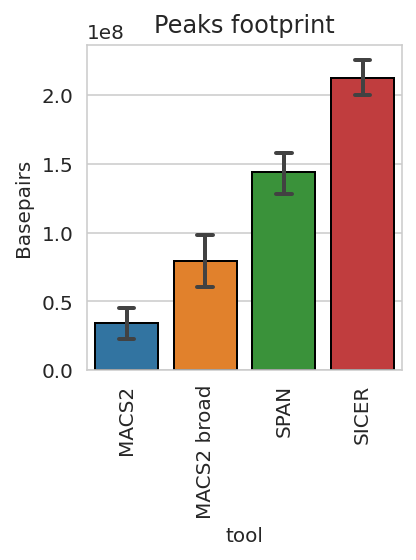

In [15]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference between narrow and broad peaks

In [16]:
! mkdir -p {GSE26320_PATH_HG38}/union

perc_ratio_df = pd.DataFrame(
    columns=['cell', 'replicate', 'length', 'tool', 'overlap_span_peaks', 'overlap_tool_peaks'],
    dtype=object
)

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['cell', 'replicate', 'length', 'tool', 'peaks'], dtype=object)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    print(c, r)
    t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K4me1') &
                     (df_fdr_peaks['cell'] == c) &
                     (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        # print(f'bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}')
        union_path = f'{GSE26320_PATH_HG38}/union/H3K4me1_{c}_{r}.bed'
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare SPAN percentage
            ! bedtools intersect -wa -u -a {t_span} -b {sorted_file(tf)} > {t_span}-perc
            # print('SPAN')
            # ! wc -l {t_span}-perc
            span_cols = len(pd.read_csv(f'{t_span}-perc', sep='\t', header=None, nrows=1).columns)
            # print('SPAN cols', span_cols)
            peak_lengths = bedl(f'{t_span}-perc')
            tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
            tl['cell'] = c
            tl['length'] = percentage_name
            tl['name'] = 'SPAN'
            perc_peaks_df.loc[len(perc_peaks_df)] = (c, r, percentage_name, 'SPAN', len(peak_lengths))
            perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SICER', t_sicer)]:
                # Prepare tool percentage peaks
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                # print(tool)
                # ! wc -l {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
                tl['cell'] = c
                tl['length'] = percentage_name
                tl['name'] = tool
                perc_peaks_df.loc[len(perc_peaks_df)] = (c, r, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

                ! bedtools intersect -a {t_span}-perc -b {file}-perc -wa -wb > {tf2}
                # print('Overlap')
                # ! wc -l {tf2}
                overlap = pd.read_csv(tf2, sep='\t', header=None)
                overlap_span_peaks = len(overlap.groupby([0, 1, 2]).count())
                overlap_tool_peaks = len(overlap.groupby([span_cols, span_cols + 1, span_cols + 2]).count())
                perc_ratio_df.loc[len(perc_ratio_df)] = (c, r, percentage_name, tool, overlap_span_peaks, overlap_tool_peaks)
    except Exception as e:
        print(e)

display(perc_ratio_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
No columns to parse from file
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,cell,replicate,length,tool,overlap_span_peaks,overlap_tool_peaks
82,HSMM,rep2,40%-60%,MACS2 broad,8576,8522
133,NHEK,rep1,80%-100%,MACS2 broad,29189,23717
208,Huvec,rep1,80%-100%,MACS2 broad,19642,19062


,peak_lengths,cell,length,name
1912026,1009.0,NHLF,80%-100%,MACS2
2239138,4815.0,Huvec,80%-100%,SPAN
2123020,468.0,Huvec,20%-40%,SPAN


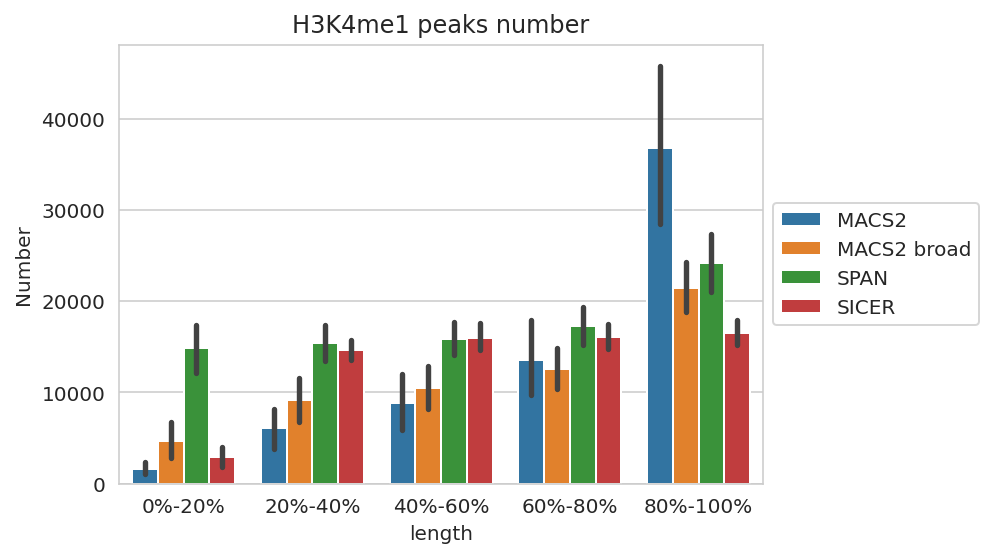

In [17]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.barplot(data=perc_peaks_df,
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K4me1 peaks number')
g_results.axes.set_ylabel('Number')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_peaks_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()

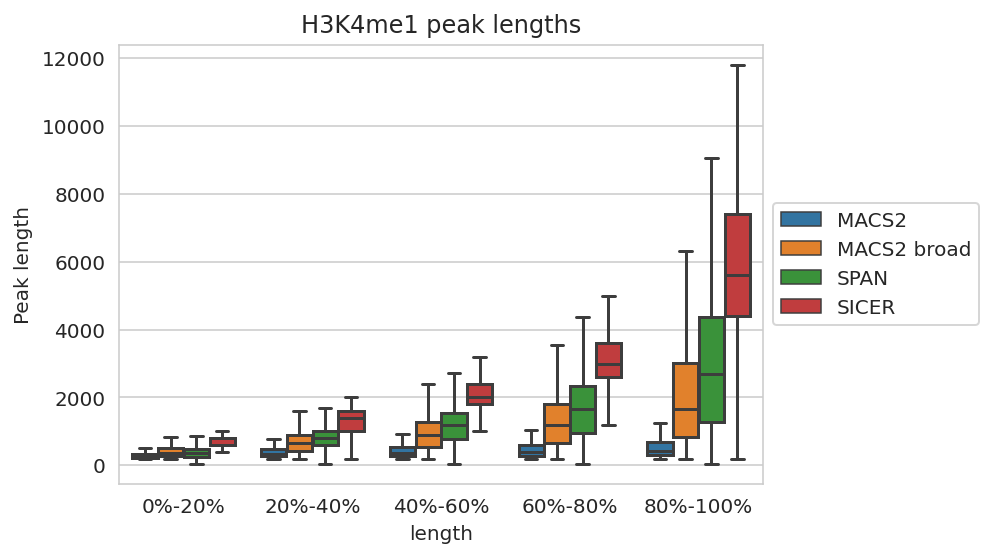

In [18]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_len_df, x='length', y='peak_lengths', ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K4me1 peak lengths')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_peak_length_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()

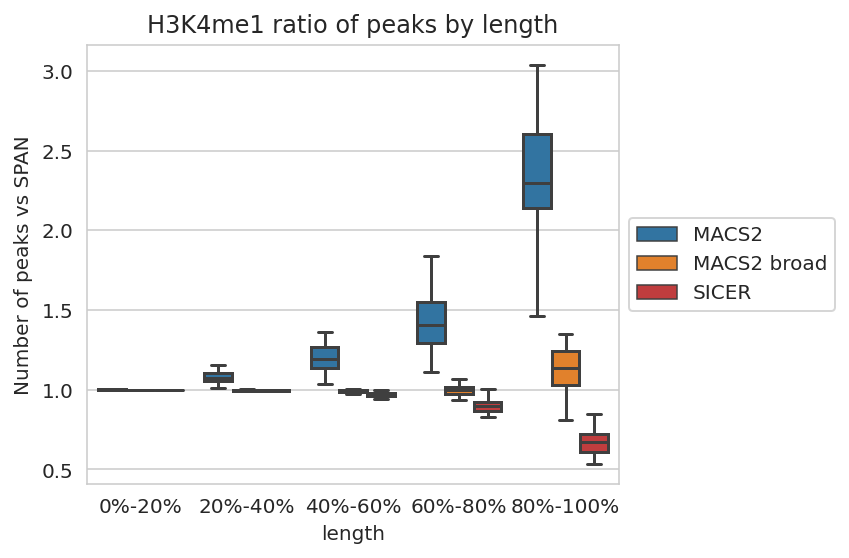

In [19]:
perc_ratio_df['tool_to_span'] = [d(t, s) for s, t in
                                 zip(perc_ratio_df['overlap_span_peaks'], perc_ratio_df['overlap_tool_peaks'])]

plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_ratio_df, x='length', y='tool_to_span', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K4me1 ratio of peaks by length')
g_results.axes.set_ylabel('Number of peaks vs SPAN')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_ratios_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Consistency analysis between replicates

In [20]:
reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks1_overlap_len',
                                     'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

tf = tempfile.mktemp()

tools = list(sorted(set(df_fdr_peaks['tool'])))
for c, m in tqdm(product(GSE26320_CELLS, GSE26320_MODIFICATIONS)):
    print(c, m)
    tm = df_fdr_peaks[(df_fdr_peaks['cell'] == c) & (df_fdr_peaks['modification'] == m)]
    reps = list(sorted(set(tm['replicate'])))
    for tool in tools:
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                if len(t1) != 1 or len(t2) != 1:
                    continue
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                peaks1_len = int(bedl(file1).sum())
                peaks2 = t2['peaks'].values[0]
                peaks2_len = int(bedl(file2).sum())
                !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                overlap1_len = overlap2_len = int(last_col(tf).sum())

                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap1_len, overlap2, overlap2_len)
reps_overlap.sample(5)

0it [00:00, ?it/s]

GM12878 H3K4me1
HMEC H3K4me1
HSMM H3K4me1
K562 H3K4me1
NHEK H3K4me1
NHLF H3K4me1
H1 H3K4me1
Huvec H3K4me1
HepG2 H3K4me1


,modification,cell,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks1_overlap_len,peaks2_overlap,peaks2_overlap_len
5,H3K4me1,HMEC,MACS2 broad,rep1,rep2,15699,17533445,99827,139890354,15642,17318202,14359,17318202
23,H3K4me1,NHLF,SPAN,rep1,rep2,72457,138354710,94069,171533635,57863,101233670,59301,101233670
29,H3K4me1,Huvec,MACS2 broad,rep1,rep2,60955,104800097,46538,61898070,35794,48343897,38121,48343897
27,H3K4me1,H1,SPAN,rep1,rep2,42833,53453459,130340,176814427,40868,48291459,38161,48291459
30,H3K4me1,Huvec,SICER,rep1,rep2,51605,197163195,70741,175789459,44233,132983287,49541,132983287


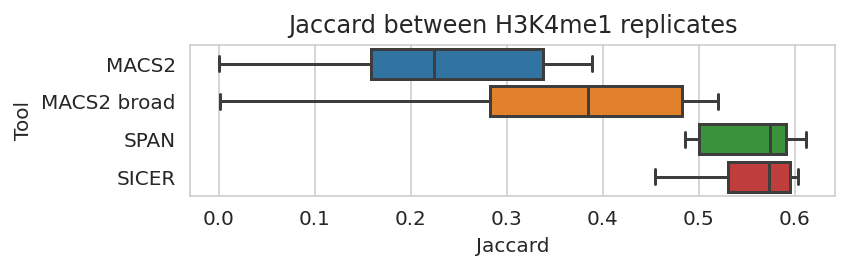

In [21]:
reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks1_overlap_len'])
]

plt.figure(figsize=(6, 2))
g_result = sns.boxplot(data=reps_overlap, y='tool', x='jaccard', palette=TOOLS_PALETTE, order=TOOLS,
                       showfliers=False)
ax = g_result.axes
ax.set_title('Jaccard between H3K4me1 replicates')
ax.set_xlabel('Jaccard')
ax.set_ylabel('Tool')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_replicates.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [22]:
reps_overlap['peak1_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks1_overlap'], reps_overlap['peaks1'])]
reps_overlap['peak2_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks2_overlap'], reps_overlap['peaks2'])]

reps_overlap['peak1_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks1_overlap_len'], reps_overlap['peaks1_len'])
]
reps_overlap['peak2_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks2_overlap_len'], reps_overlap['peaks2_len'])
]
reps_overlap.sample(5)

,modification,cell,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks1_overlap_len,peaks2_overlap,peaks2_overlap_len,jaccard,peak1_overlap_fraction,peak2_overlap_fraction,peak1_overlap_fraction_len,peak2_overlap_fraction_len
27,H3K4me1,H1,SPAN,rep1,rep2,42833,53453459,130340,176814427,40868,48291459,38161,48291459,0.265372,0.954124,0.292780,0.903430,0.273119
6,H3K4me1,HMEC,SICER,rep1,rep2,69082,216118518,96949,248295851,65825,172856875,66719,172856875,0.592874,0.952853,0.688187,0.799824,0.696173
5,H3K4me1,HMEC,MACS2 broad,rep1,rep2,15699,17533445,99827,139890354,15642,17318202,14359,17318202,0.123608,0.996369,0.143839,0.987724,0.123798
22,H3K4me1,NHLF,SICER,rep1,rep2,66313,158251287,72197,222200403,52749,120272008,48659,120272008,0.462265,0.795455,0.673975,0.760007,0.541277
9,H3K4me1,HSMM,MACS2 broad,rep1,rep2,66078,96703823,51163,56908124,34844,40724069,37877,40724069,0.360748,0.527316,0.740320,0.421122,0.715611


In [23]:
t = pd.concat([
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak1_overlap_fraction', 'peak1_overlap_fraction_len']
    ].copy().rename(dict(peak1_overlap_fraction='overlap', peak1_overlap_fraction_len='overlap_len'), axis=1),
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak2_overlap_fraction', 'peak2_overlap_fraction_len']
    ].copy().rename(dict(peak2_overlap_fraction='overlap', peak2_overlap_fraction_len='overlap_len'), axis=1)
]).reset_index(drop=True)
# t

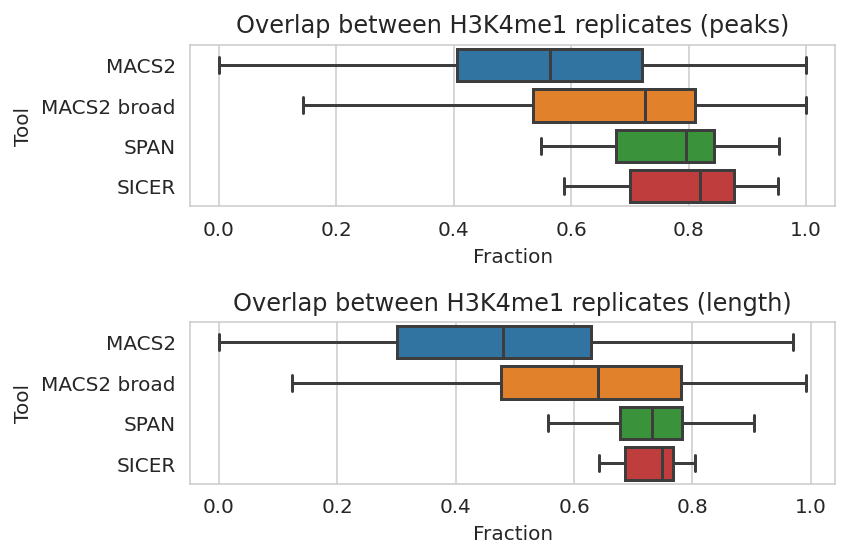

In [24]:
plt.figure(figsize=(6, 4))
axs = [plt.subplot(2, 1, i + 1) for i in range(2)]

g_result = sns.boxplot(data=t, y='tool', x='overlap', ax=axs[0], palette=TOOLS_PALETTE,
                       order=TOOLS, showfliers=False)
ax = g_result.axes
ax.set_title('Overlap between H3K4me1 replicates (peaks)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

g_result = sns.boxplot(data=t, y='tool', x='overlap_len', ax=axs[1], palette=TOOLS_PALETTE,
                       order=TOOLS, showfliers=False)
ax = g_result.axes
ax.set_title('Overlap between H3K4me1 replicates (length)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

plt.tight_layout()
plt.show()

In [25]:
reps_overlap.to_csv(GSE26320_PATH_HG38 + '/H3K4me1_reps_overlap.csv.gz', index=False, compression='gzip')

# Consistency between replicates by length

In [26]:
import tempfile
from itertools import product

perc_reps_overlap = pd.DataFrame(
    columns=['modification', 'cell', 'tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)


for c in tqdm(GSE26320_CELLS):
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()
    tf3 = tempfile.mktemp()

    print(c)
    try:
        rep_tool_map = {}
        for r, tool in product(GSE26320_REPS, ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']):
            t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K4me1') &
                             (df_fdr_peaks['cell'] == c) &
                             (df_fdr_peaks['replicate'] == r) &
                             (df_fdr_peaks['tool'] == tool)]
            if len(t) > 0:
                rep_tool_map[(r, tool)] = sorted_file(t['file'].values[0])
        # Prepare global overlap 
        tr1_macs2 = rep_tool_map[('rep1', 'MACS2')]
        tr1_macs2broad = rep_tool_map[('rep1', 'MACS2 broad')]
        tr1_span = rep_tool_map[('rep1', 'SPAN')]
        tr1_sicer = rep_tool_map[('rep1', 'SICER')]
        tr2_macs2 = rep_tool_map[('rep2', 'MACS2')]
        tr2_macs2broad = rep_tool_map[('rep2', 'MACS2 broad')]
        tr2_span = rep_tool_map[('rep2', 'SPAN')]
        tr2_sicer = rep_tool_map[('rep2', 'SICER')]
        ! bedtools multiinter -i {tr1_macs2} {tr1_macs2broad} {tr1_span} {tr1_sicer} \
                {tr2_macs2} {tr2_macs2broad} {tr2_span} {tr2_sicer} > {tf}
        ! bedtools merge -i {tf} > {tf2}
        t = pd.read_csv(tf2, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare tools percentage
            for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
                r1file = rep_tool_map[('rep1', tool)]
                r2file = rep_tool_map[('rep2', tool)]
                ! bedtools intersect -wa -u -a {r1file} -b {sorted_file(tf)} > {r1file}-perc
                ! bedtools intersect -wa -u -a {r2file} -b {sorted_file(tf)} > {r2file}-perc
                r1file = f'{r1file}-perc'
                r2file = f'{r2file}-perc'
                r1_peaks = lines(r1file)
                r2_peaks = lines(r2file)
                r1_len = int(bedl(r1file).sum())
                r2_len = int(bedl(r2file).sum())
                !bedtools intersect -a {r1file} -b {r2file} -wa -u > {tf3}
                overlap1 = lines(tf3)
                !bedtools intersect -b {r1file} -a {r2file} -wa -u > {tf3}
                overlap2 = lines(tf3)
                !bedtools intersect -a {r1file} -b {r2file} -wo > {tf3}
                overlap1_len = overlap2_len = int(last_col(tf3).sum())
                perc_reps_overlap.loc[len(perc_reps_overlap)] = \
                    ('H3K4me1', c, tool, percentage_name, r1_peaks, r1_len, r2_peaks, r2_len,
                     overlap1, overlap1_len, overlap2, overlap2_len)

    except Exception as e:
        print(e)

perc_reps_overlap.sample(5)

  0%|          | 0/9 [00:00<?, ?it/s]

GM12878
HMEC
HSMM
K562
NHEK
NHLF
H1
Huvec
HepG2
('rep2', 'MACS2')


,modification,cell,tool,length_percentage,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks1_overlap_len,peaks2_overlap,peaks2_overlap_len
157,H3K4me1,Huvec,MACS2 broad,80%-100%,23914,64196717,20549,37539625,17153,32781352,19340,32781352
72,H3K4me1,K562,MACS2,60%-80%,22332,9231879,9973,5481839,8863,3374018,7917,3374018
83,H3K4me1,NHEK,SICER,0%-20%,146,82454,132,75468,7,3793,7,3793
148,H3K4me1,Huvec,MACS2,40%-60%,12616,6653589,6902,3009187,3763,1242861,3916,1242861
40,H3K4me1,HSMM,MACS2,0%-20%,562,171112,68,18352,7,1834,7,1834


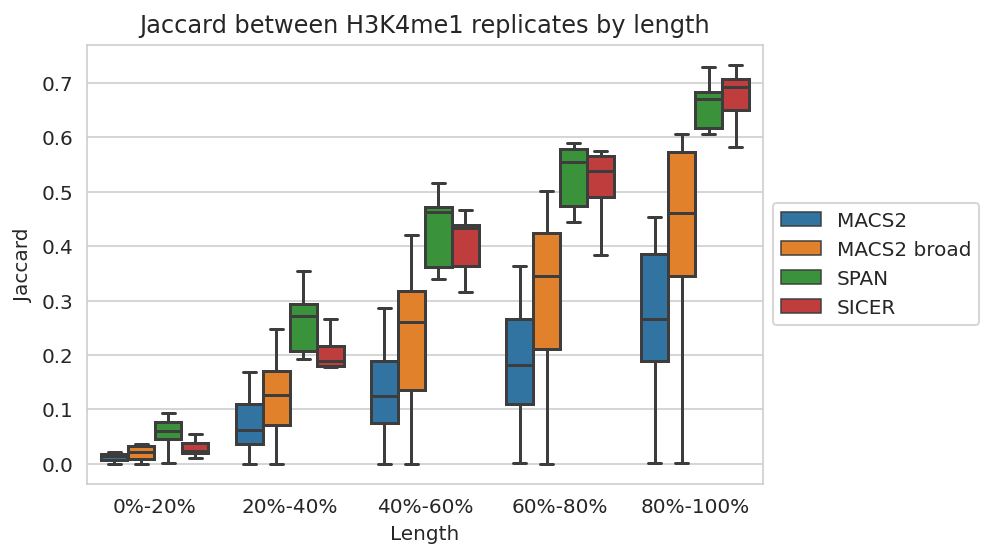

In [27]:
perc_reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(perc_reps_overlap['peaks1_len'], perc_reps_overlap['peaks2_len'],
                          perc_reps_overlap['peaks1_overlap_len'])
]

plt.figure(figsize=(7, 4))

g_result = sns.boxplot(data=perc_reps_overlap, x='length_percentage', y='jaccard',
                       hue='tool',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False,
                       )
ax = g_result.axes
ax.set_title('Jaccard between H3K4me1 replicates by length')
ax.set_xlabel('Length')
ax.set_ylabel('Jaccard')
# Put a legend to the right of the current axis
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_replicates_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

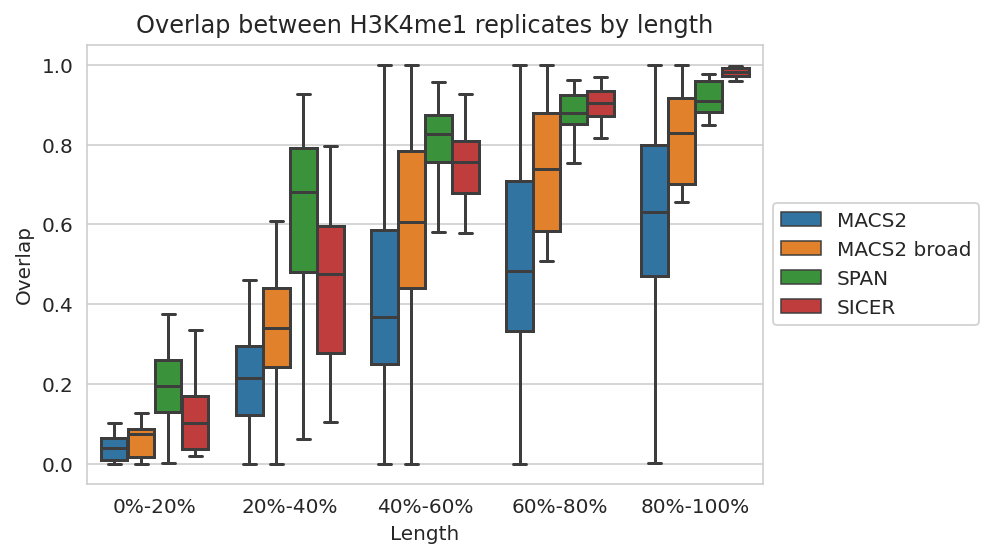

In [28]:
perc_reps_overlap['overlap1'] = [d(o, p) for o, p in
                                 zip(perc_reps_overlap['peaks1_overlap'], perc_reps_overlap['peaks1'])]
perc_reps_overlap['overlap2'] = [d(o, p) for o, p in
                                 zip(perc_reps_overlap['peaks2_overlap'], perc_reps_overlap['peaks2'])]

t = perc_reps_overlap[['tool', 'length_percentage', 'overlap1', 'overlap2']].copy().melt(
    id_vars=['tool', 'length_percentage'], value_vars=['overlap1', 'overlap2'])


plt.figure(figsize=(7, 4))

g_result = sns.boxplot(data=t, x='length_percentage', y='value',
                       hue='tool',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
ax = g_result.axes
ax.set_title('Overlap between H3K4me1 replicates by length')
ax.set_xlabel('Length')
ax.set_ylabel('Overlap')
# Put a legend to the right of the current axis
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_replicates_overlap_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Analyze peaks and diffs

In [29]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name', 'peaks'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        peaks = lines(peaks_file)
        bench_df.loc[len(bench_df)] = (c, r, tool, peaks)
# bench_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


In [30]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K4me1') &
                     (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            diff_bench_df.loc[len(diff_bench_df)] = (c, r, name, peaks)

# display(diff_bench_df.head())

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


In [31]:
full_bench_df = pd.concat([
    bench_df[['cell', 'replicate', 'name', 'peaks']],
    diff_bench_df[['cell', 'replicate', 'name', 'peaks']]]).reset_index(drop=True)
full_bench_df.sample(10)

,cell,replicate,name,peaks
34,NHEK,rep1,MACS2,110303
78,GM12878,rep2,SPAN - SICER,10592
26,K562,rep1,MACS2,119713
6,GM12878,rep2,MACS2,42605
88,HMEC,rep2,SPAN - MACS2 broad,35021
114,K562,rep2,SPAN - SICER,10339
44,NHLF,rep2,MACS2 broad,43243
80,HMEC,rep1,SPAN - MACS2,90490
0,GM12878,rep1,MACS2 broad,42927
91,HMEC,rep2,SICER - SPAN,230


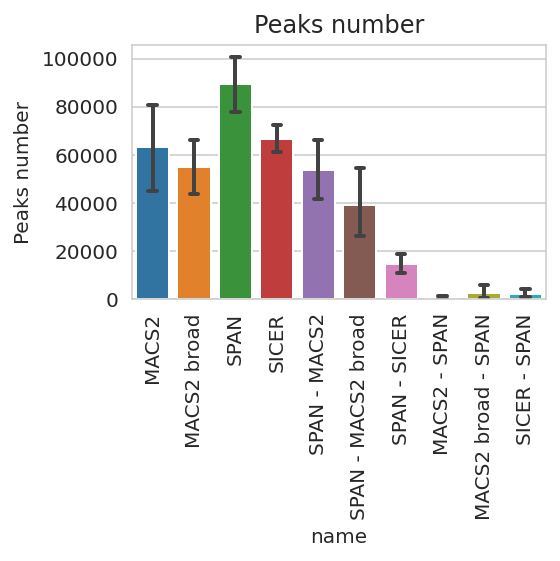

In [32]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df, x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ]
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

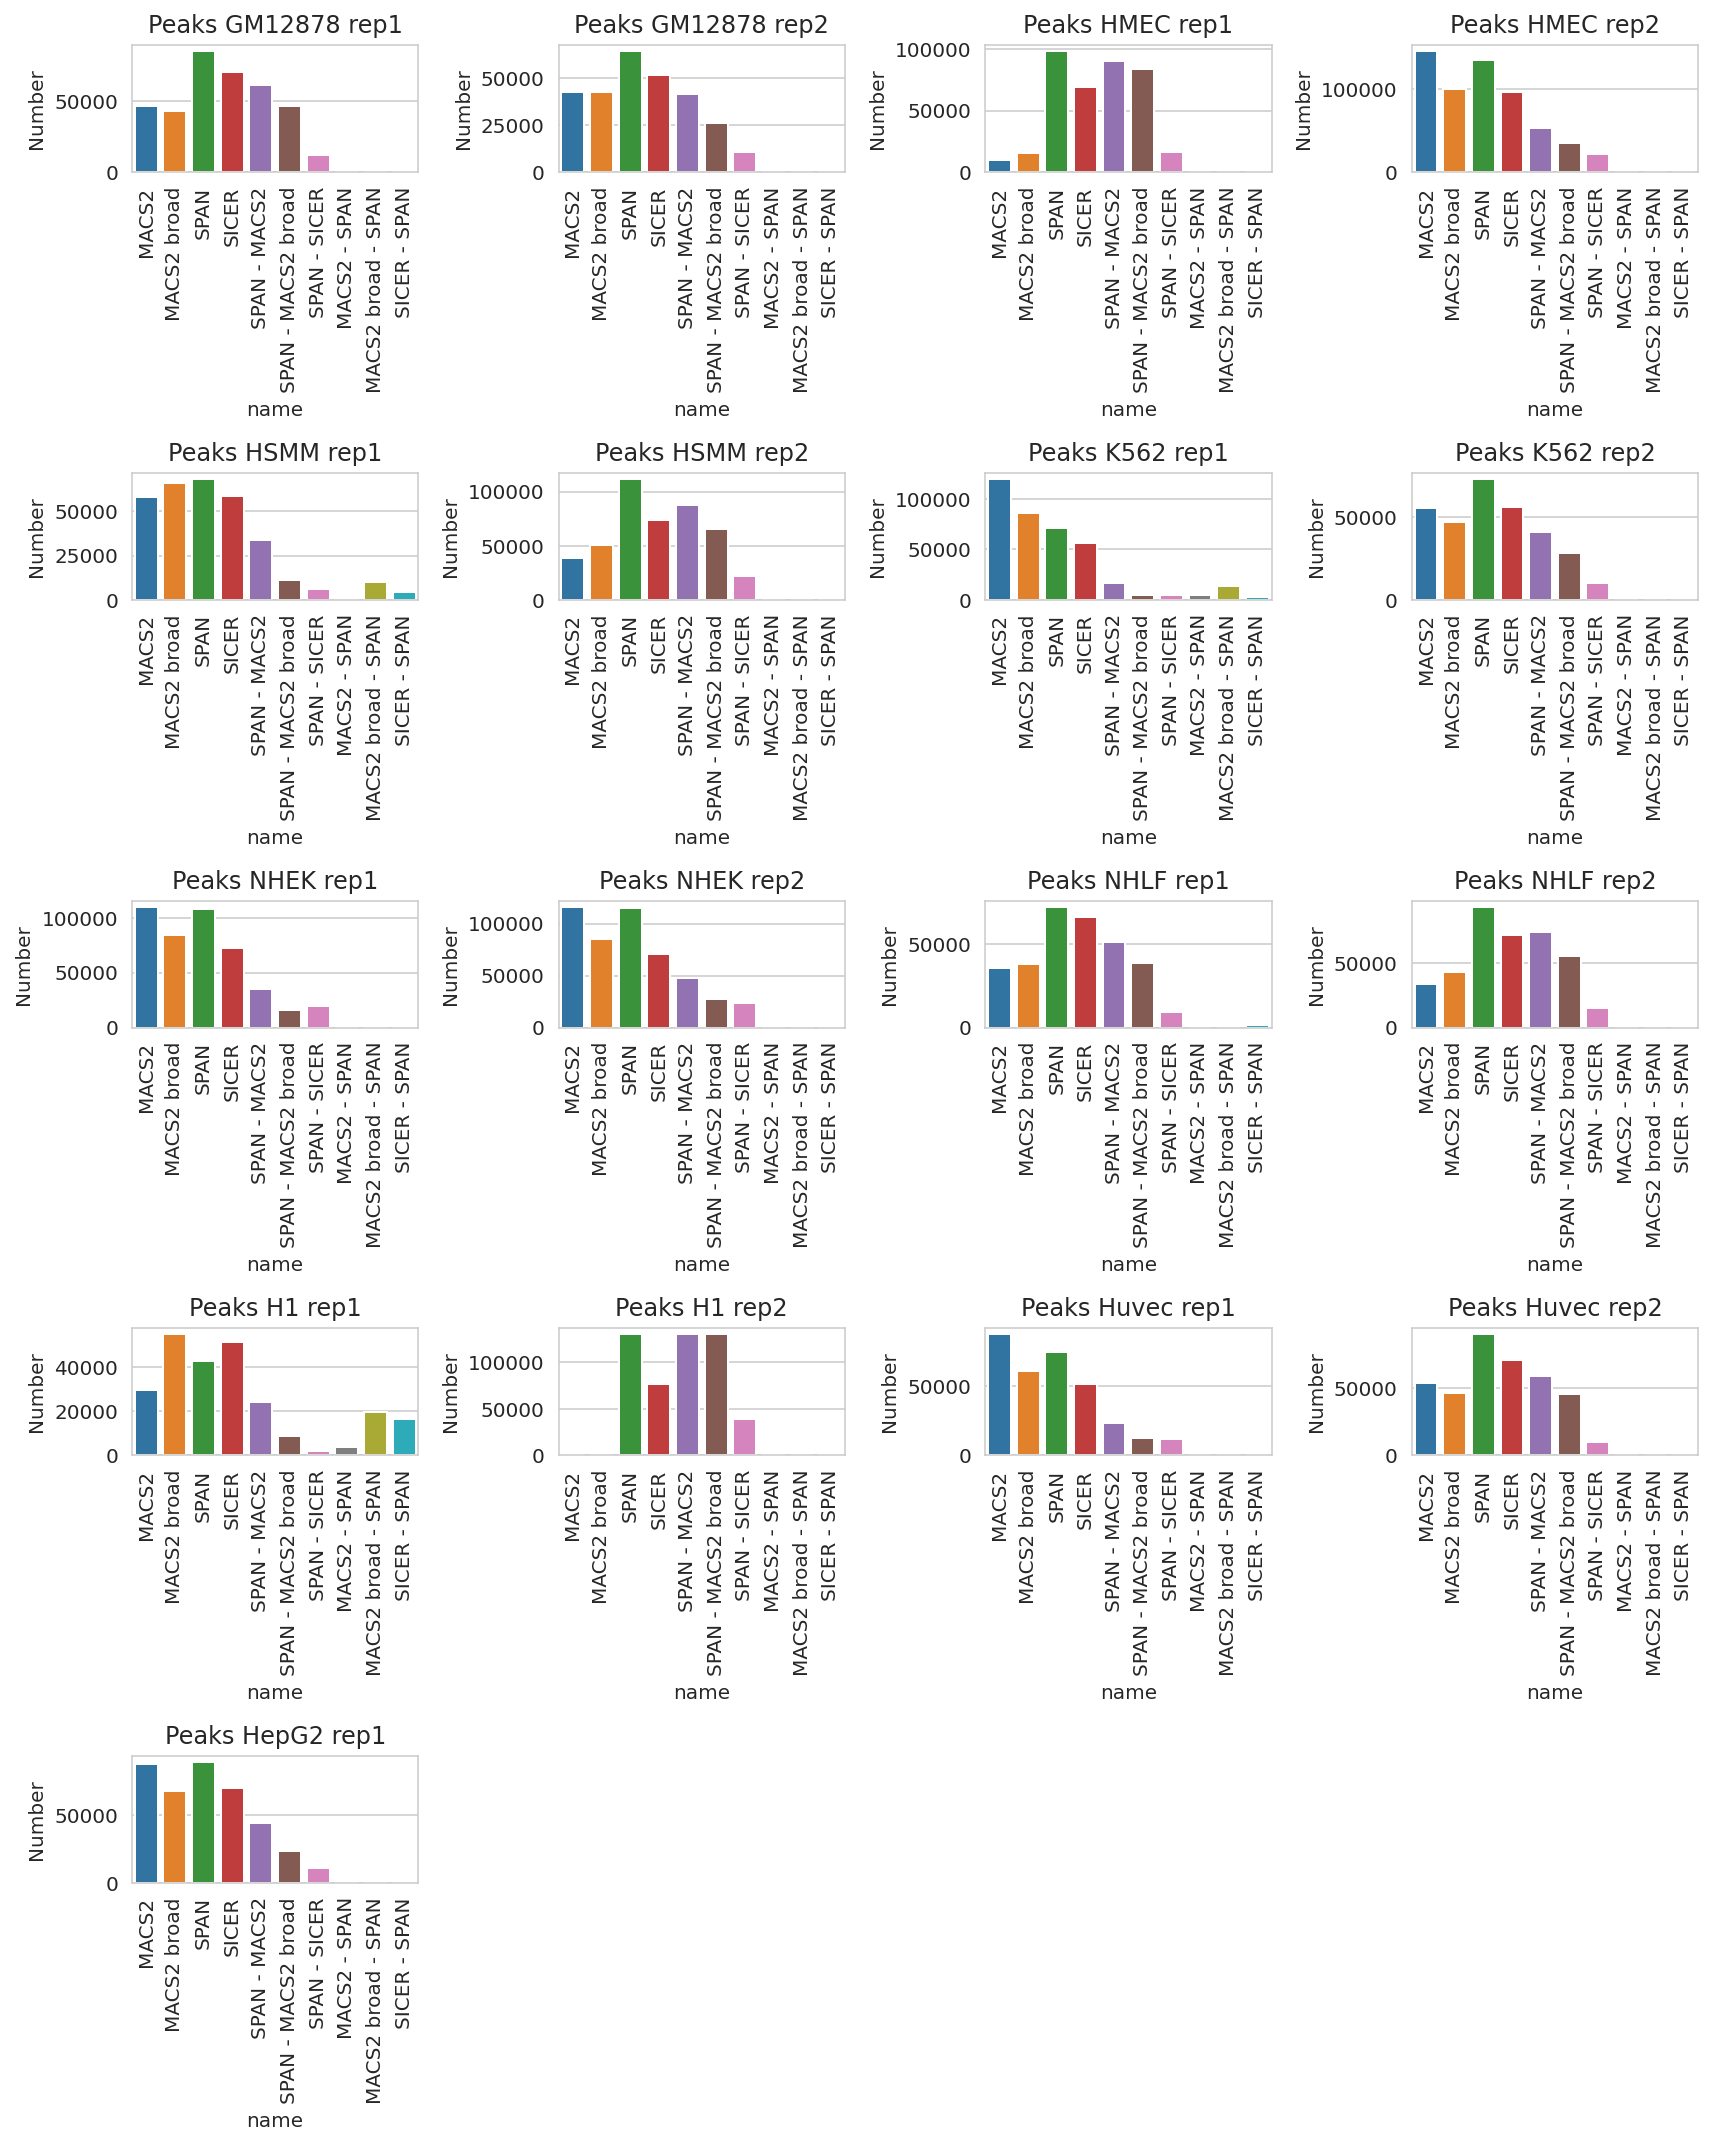

In [33]:
import math
experiments = [(c, r) for c, r in product(GSE26320_CELLS, GSE26320_REPS)
               if sum((full_bench_df['cell'] == c) & (full_bench_df['replicate'] == r)) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, (c, r) in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c} {r}')
    g_results = sns.barplot(data=full_bench_df[(full_bench_df['cell'] == c) & (full_bench_df['replicate']==r)],
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Number')
plt.tight_layout()
plt.show()

## Save benchmark df

In [34]:
full_bench_df.to_csv(GSE26320_PATH_HG38 + '/H3K4me1_full_bench_df.csv.gz', index=False, compression='gzip')

# Functional annotation

In [35]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

! rm -r {GSE26320_PATH_HG38}/summary_H3K4me1
! mkdir -p {GSE26320_PATH_HG38}/summary_H3K4me1

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        filename = tool.replace(' ', '_')
        ! cat {peaks_file} >> "{GSE26320_PATH_HG38}/summary_H3K4me1/{filename}.bed_"
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            filename = name.replace(' ', '_')
            ! cat {tf} >> "{GSE26320_PATH_HG38}/summary_H3K4me1/{filename}.bed_"

for f in os.listdir(GSE26320_PATH_HG38 + '/summary_H3K4me1'):
    f_sorted = f[:len(f) - 1]
    ! sort -k1,1 -k2,2n -k3,3n "{GSE26320_PATH_HG38}/summary_H3K4me1/{f}" | cut -f1-3> "{GSE26320_PATH_HG38}/summary_H3K4me1/{f_sorted}"
    ! rm "{GSE26320_PATH_HG38}/summary_H3K4me1/{f}"

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


# Coverage

In [36]:
# Fraction of reads in peaks
GSE26320_PATH_HG38_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [37]:
bws_df = load_bws(GSE26320_PATH_HG38_BW, 'H3K4me1')
display(bws_df.sample(3))
bws_control_df = load_bws(GSE26320_PATH_HG38_BW, 'Input')
display(bws_control_df.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
7,/home/jetbrains/data/2023_GSE26320/bw/GSM64640...,H3K4me1,HSMM,rep2
3,/home/jetbrains/data/2023_GSE26320/bw/GSM64640...,H3K4me1,HSMM,rep1
0,/home/jetbrains/data/2023_GSE26320/bw/GSM64632...,H3K4me1,GM12878,rep1


  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
2,/home/jetbrains/data/2023_GSE26320/bw/GSM64649...,Input,NHLF,rep2
14,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,Input,Huvec,rep1
3,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,Input,Huvec,rep2


In [38]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [39]:
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'replicate', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # for c, r in tqdm(product(['GM12878'], ['rep1'])):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K4me1') &
                   (bws_df['cell'] == c) & (bws_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]))
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(
                bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        frip_df.loc[len(frip_df)] = (c, r, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

0it [00:00, ?it/s]

GM12878 rep1
MACS2 broad /tmp/tmp9vah5z6h /home/jetbrains/data/2023_GSE26320/bw/GSM646322_GM12878_H3K4me1_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SICER /tmp/tmp5mxkqtu9 /home/jetbrains/data/2023_GSE26320/bw/GSM646322_GM12878_H3K4me1_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
MACS2 /tmp/tmpod47unc_ /home/jetbrains/data/2023_GSE26320/bw/GSM646322_GM12878_H3K4me1_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SPAN /tmp/tmpg03fxokp /home/jetbrains/data/2023_GSE26320/bw/GSM646322_GM12878_H3K4me1_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
GM12878 rep2
MACS2 broad /tmp/tmpdtwnzdge /home/jetbrains/data/2023_GSE26320/bw/GSM646323_GM12878_H3K4me1_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM12878_Input_rep2.bw
SICER /tmp/tmps8dy2wm4 /home/jetbrains/data/2023_GSE26320/bw/GSM646323_GM12878_H3K4me1_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM64

,cell,replicate,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads
0,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64632...,MACS2 broad,/tmp/tmp9vah5z6h,42927,77267021,2.781894e+07,9.705751e+07,3.534075e+06,9.856627e+07
1,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64632...,SICER,/tmp/tmp5mxkqtu9,70985,207717415,4.777401e+07,9.703773e+07,1.014571e+07,9.856627e+07
2,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64632...,MACS2,/tmp/tmpod47unc_,46817,28165581,1.435839e+07,9.705751e+07,9.572188e+05,9.856627e+07
3,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64632...,SPAN,/tmp/tmpg03fxokp,85381,179663785,4.521397e+07,9.708213e+07,8.941039e+06,9.856627e+07
4,GM12878,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64632...,MACS2 broad,/tmp/tmpdtwnzdge,42538,74770331,2.646593e+07,9.557880e+07,3.688480e+06,9.837757e+07
...,...,...,...,...,...,...,...,...,...,...,...
63,Huvec,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64642...,SPAN,/tmp/tmp0pa02e7g,90144,131174908,4.541374e+07,7.503789e+07,8.680758e+06,7.680974e+07
64,HepG2,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64636...,MACS2 broad,/tmp/tmptyeq91li,67313,118587825,3.091732e+07,7.463945e+07,4.792074e+06,8.086781e+07
65,HepG2,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64636...,SICER,/tmp/tmpsf7l0b7o,69630,216630170,4.046017e+07,7.461068e+07,9.238711e+06,8.086781e+07
66,HepG2,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64636...,MACS2,/tmp/tmp256ynl2u,87117,53136153,2.017971e+07,7.463945e+07,2.040663e+06,8.086781e+07


In [40]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / ((z + 1e-10) / 1e3)) / ((y + 1e-10) / 1e6) for x, y, z in
                         zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / (z + 1e-10)) / ((y - x) / (sum(CHROM_SIZES.values()) - z + 1e-10)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / ((y + 1e-10) / 1e6), z / ((u + 1e-10) / 1e6) + 1e-10))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

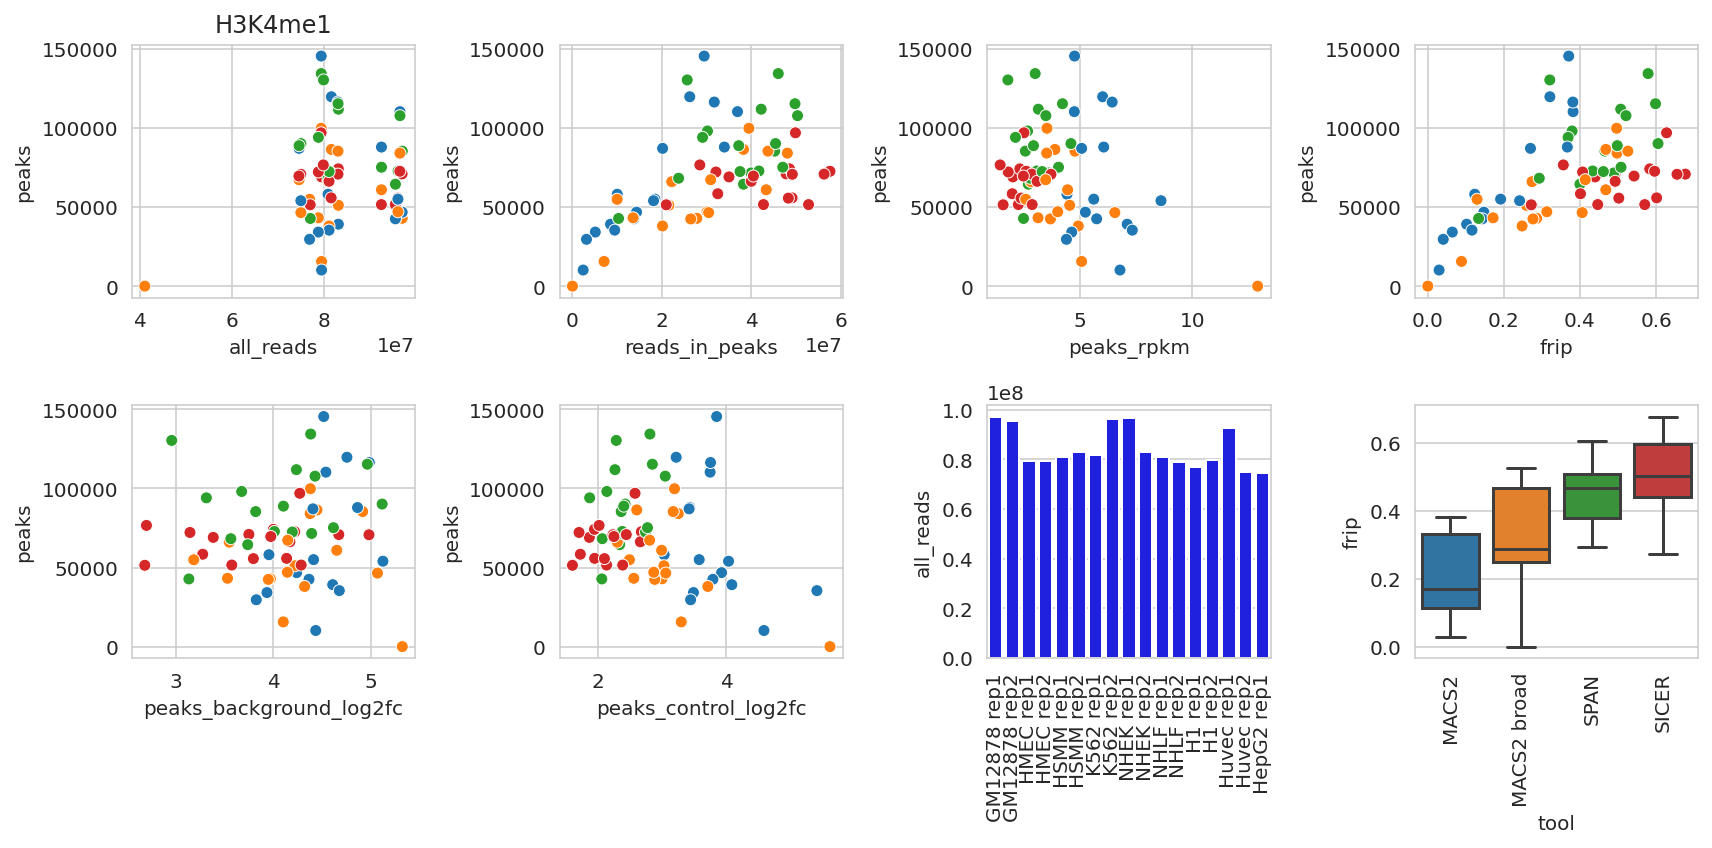

In [41]:
import seaborn as sns

# Ignore oultier
t = frip_df[frip_df['peaks_control_log2fc'] < 10]

plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K4me1')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
tt = t[t['tool'] == 'SPAN']
g_results = sns.barplot(x=tt['cell'] + ' ' + tt['replicate'], y=tt['all_reads'],
                        color='Blue',
                        # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='frip',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [42]:
frip_df.to_csv(f'{GSE26320_PATH_HG38}/pics/H3K4me1_frip.csv.gz', index=None, compression='gzip')

## Peaks density

In [43]:
import pyBigWig

tf = tempfile.mktemp()

coverage_data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    t = bws_df[(bws_df['modification'] == 'H3K4me1') &
               (bws_df['cell'] == c) &
               (bws_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me1', c, r, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me1', c, r, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me1', c, r, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me1', c, r, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'replicate', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,modification,cell,replicate,name,position,length,type,coverage,total_coverage
10065905,H3K4me1,H1,rep2,SICER,chr2:176465000-176467399,2399,control,16.340422,8.395459e+07
4293267,H3K4me1,HSMM,rep2,SPAN,chr6:46652003-46652687,684,treatment,172.749798,8.317654e+07
7692611,H3K4me1,NHEK,rep2,SPAN,chr5:143105519-143106477,958,treatment,416.206760,8.309886e+07
11181074,H3K4me1,Huvec,rep1,SICER,chr7:100794000-100795399,1399,control,92.607150,9.448221e+07
11024240,H3K4me1,Huvec,rep1,MACS2 broad,chr1:15747285-15751268,3983,control,248.838999,9.449735e+07


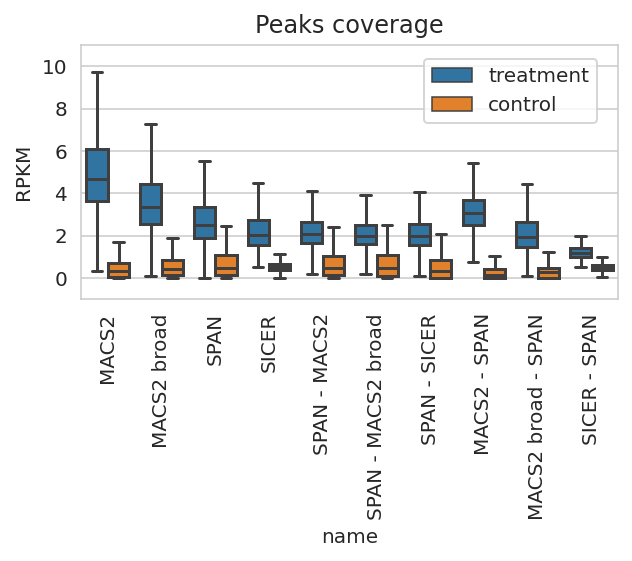

In [44]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 11)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [45]:
CHROMHMM_MAP = {
    'GM12878': GSE26320_PATH_HG38 + '/chromhmm/GM12878_chromhmm_hg38_ENCFF338RIC.bed',
    'H1': GSE26320_PATH_HG38 + '/chromhmm/H1_chromhmm_hg38_ENCFF323HNB.bed',
    'HepG2': GSE26320_PATH_HG38 + '/chromhmm/HepG2_chromhmm_hg38_ENCFF808IZE.bed',
    'K562': GSE26320_PATH_HG38 + '/chromhmm/K562_chromhmm_hg38_ENCFF649FCE.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}
CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
GM12878
H1
HepG2
K562
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [46]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, r, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me1') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, r, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'replicate', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,cell,replicate,name,peaks,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
0,GM12878,rep1,MACS2 broad,42927,14550,6562,600,4151,1598,32948,...,1883,1748,3360,166,12116,6896,6174,13684,13142,0
1,GM12878,rep1,SICER,70985,13972,8419,1754,6877,1600,45511,...,10807,10140,10043,758,20717,11383,7562,42639,40410,0
2,GM12878,rep1,MACS2,46817,21120,3592,245,2684,1844,28901,...,565,536,945,39,7927,3377,4885,3854,3703,0
3,GM12878,rep1,SPAN,85381,14236,8548,1998,7124,1632,48353,...,11395,10417,8673,802,22013,11824,7739,44324,41349,0
4,GM12878,rep1,SPAN - MACS2,61264,2724,2752,1611,3769,287,27363,...,8934,8044,4952,695,13751,7117,2783,27807,25527,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,HepG2,rep1,MACS2 - SPAN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,HepG2,rep1,SPAN - MACS2 broad,23482,263,152,1902,1837,34,12336,...,4120,2991,1292,470,3160,1876,498,8505,7235,0
67,HepG2,rep1,MACS2 broad - SPAN,270,2,1,42,12,0,94,...,69,50,6,16,26,9,3,81,67,0
68,HepG2,rep1,SPAN - SICER,10957,39,31,919,575,7,4612,...,2261,1631,252,256,894,455,75,3127,2579,0


In [47]:
chromhmm_df_mean = chromhmm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_df_mean = chromhmm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                         ]]
chromhmm_df_mean

,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,Quies,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
name,,,,,,,,,,,,,,,,,,
MACS2,15428.285714,2603.857143,1918.571429,2596.714286,1602.714286,25899.714286,174.714286,8258.000000,1629.571429,1136.571429,1391.000000,1594.428571,10593.000000,4711.571429,6454.285714,7595.142857,7004.285714,0.0
MACS2 broad,11293.285714,4068.857143,2680.142857,3359.000000,1315.857143,28042.000000,349.000000,12041.142857,3680.714286,2612.142857,3403.571429,2098.714286,12763.857143,6913.714286,7079.000000,13920.285714,12957.285714,0.0
SPAN,13357.857143,6334.857143,4670.571429,5075.285714,1458.857143,43485.571429,1085.285714,26049.000000,9278.142857,6844.857143,7031.285714,3725.714286,19585.857143,10524.571429,9200.428571,32108.571429,29960.000000,0.0
SICER,12942.000000,6770.714286,4492.428571,5041.000000,1439.714286,39642.714286,1465.000000,26082.857143,10682.000000,8574.857143,9191.285714,3472.000000,18432.142857,10388.857143,9074.857143,34618.857143,32911.428571,0.0
SPAN - MACS2,4229.285714,2855.714286,2780.428571,2306.000000,302.714286,24762.428571,714.714286,17721.857143,6417.428571,4691.428571,3701.857143,2318.000000,10061.428571,5326.714286,3159.857143,19572.714286,18212.857143,0.0
SPAN - MACS2 broad,2761.428571,2086.285714,1989.000000,1444.428571,169.714286,17492.571429,549.571429,14231.428571,4914.571429,3574.000000,2457.857143,1741.000000,6759.714286,3338.571429,1899.428571,14772.000000,13751.285714,0.0
SPAN - SICER,225.000000,253.714286,382.571429,256.714286,16.285714,3763.142857,200.714286,5642.285714,1459.714286,1153.285714,310.714286,259.285714,1178.571429,445.285714,266.285714,3305.428571,2950.571429,0.0
MACS2 - SPAN,65.571429,29.428571,38.428571,13.857143,2.000000,351.571429,11.571429,502.857143,96.714286,68.428571,17.142857,54.857143,102.285714,46.142857,46.285714,187.000000,165.857143,0.0
MACS2 broad - SPAN,271.000000,190.285714,149.428571,63.000000,9.000000,1613.000000,45.428571,2031.428571,407.428571,288.428571,111.142857,170.142857,431.285714,201.285714,148.000000,1056.571429,967.428571,0.0


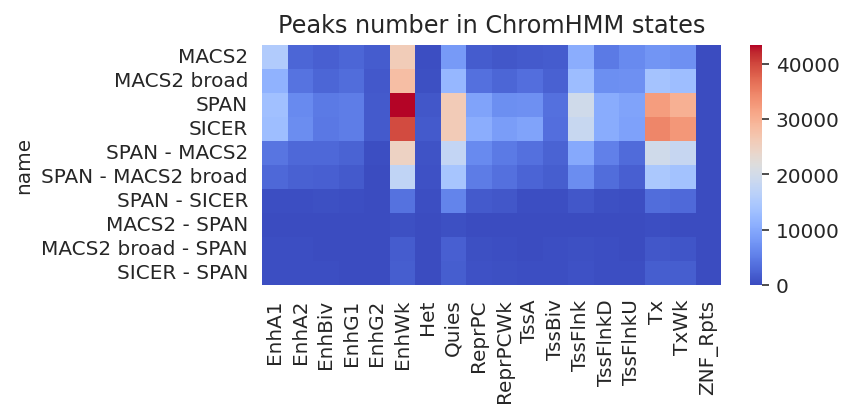

In [48]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_df_mean, cmap='coolwarm')
plt.title('Peaks number in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [49]:
chromhmm_rel_df = chromhmm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,Quies,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
name,,,,,,,,,,,,,,,,,,
MACS2,0.327173,0.043824,0.040526,0.040562,0.041649,0.444998,0.002277,0.103588,0.022715,0.015504,0.021930,0.038292,0.236190,0.075063,0.168863,0.106157,0.098789,0.0
MACS2 broad,0.308986,0.084693,0.052905,0.061512,0.034651,0.553556,0.006197,0.196270,0.060701,0.043662,0.061788,0.041890,0.276308,0.133338,0.170639,0.247092,0.230988,0.0
SPAN,0.179096,0.081279,0.060840,0.064721,0.019226,0.548431,0.013683,0.310692,0.113458,0.083470,0.089553,0.050471,0.252769,0.135678,0.122268,0.391114,0.364196,0.0
SICER,0.213730,0.111521,0.071879,0.081329,0.023674,0.636655,0.024173,0.426907,0.171277,0.137654,0.150157,0.056586,0.299264,0.167172,0.151177,0.558515,0.530990,0.0
SPAN - MACS2,0.079706,0.047851,0.053691,0.046223,0.006358,0.450760,0.013948,0.326187,0.121115,0.089567,0.070687,0.043512,0.197763,0.104608,0.069190,0.347660,0.318617,0.0
SPAN - MACS2 broad,0.056421,0.038287,0.048744,0.040134,0.004514,0.398355,0.014508,0.332311,0.124326,0.092957,0.060432,0.038196,0.170583,0.082346,0.052949,0.337013,0.304281,0.0
SPAN - SICER,0.028285,0.021110,0.036494,0.022886,0.002259,0.294208,0.016098,0.383923,0.125082,0.098109,0.027732,0.024654,0.104506,0.042940,0.028699,0.245865,0.214735,0.0
MACS2 - SPAN,0.016433,0.007271,0.009177,0.003334,0.143266,0.089058,0.002457,0.109054,0.021279,0.014913,0.004014,0.012844,0.024271,0.011390,0.010330,0.043525,0.038971,0.0
MACS2 broad - SPAN,0.015770,0.019783,0.039645,0.009849,0.017308,0.214191,0.029178,0.284977,0.104977,0.069836,0.034690,0.027351,0.081326,0.024814,0.036052,0.173393,0.134568,0.0


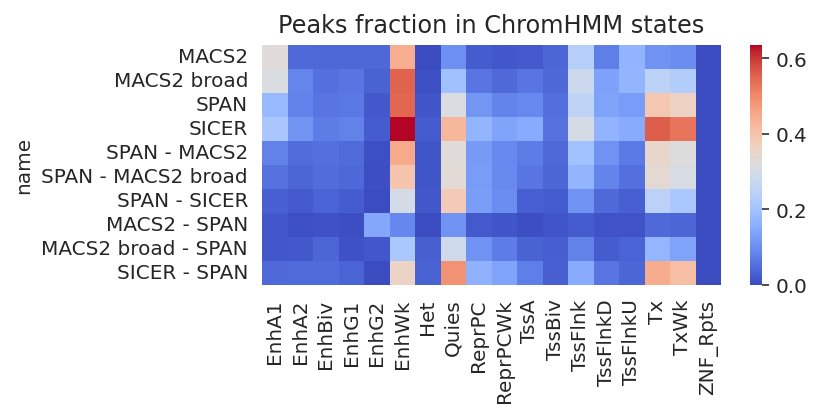

In [50]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()